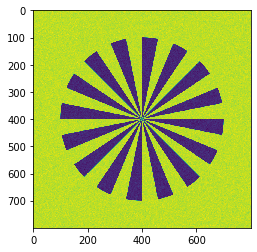

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import kornia
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from kornia.feature import *
from kornia.geometry import *

def visualize_LAF(img, LAF, img_idx = 0):
    x, y = kornia.feature.laf.get_laf_pts_to_draw(LAF, img_idx)
    plt.figure()
    plt.imshow(kornia.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'r')
    plt.show()
    return

img = Image.open('img/siemens.png')
# Image with synthetic pattern from SFOP paper: 
# http://www.ipb.uni-bonn.de/data-software/sfop-keypoint-detector/

timg = kornia.utils.image_to_tensor(np.array(img)).float() / 255. / 255. 
#Yes, it is not a typo. 
#This specific image somehow has [0, 255**2] range

plt.imshow(kornia.utils.tensor_to_image(timg[0]))

Kornia has a module ScaleSpaceDetector for local feature extraction.
It consists of several modules, each one is tunable and differentiable:

1. Scale pyramid
2. Responce (aka "cornerness")
3. Soft non-maxima-suppression
4. Affine shape detector
5. Orientation detector

The output is two tensors: with responces and with local affine frames (LAFs). You can feed LAFs to extract_patches function to then describe the corresponding patches

In [2]:
#Lets detect Harris corners
n_feats = 100
mr_size = 3.0 
nms = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), # nms windows size (scale, height, width)
                                       stride=(1,2,2), # stride (scale, height, width)
                                       padding=(0, 1, 1)) # nms windows size (scale, height, width)
harris = kornia.feature.responses.CornerHarris(0.04)

harris_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=harris,
                                    nms_module=nms,
                                    mr_size=mr_size)
print (harris_local_detector)


ScaleSpaceDetector(num_features=100, mr_size=3.0, scale_pyr=ScalePyramid(n_levels=3, init_sigma=1.6, min_size=10, border=4, sigma_step=1.2599210498948732), resp=CornerHarris(k=tensor(0.0400), grads_mode=sobel), nms=ConvSoftArgmax3d(kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), temperature=tensor(1.), normalized_coordinates=False, eps=1e-08, output_value=True), ori=PassLAF(), aff=PassLAF())


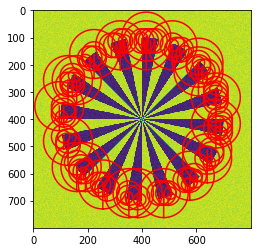

In [3]:
lafs, resps = harris_local_detector(timg)
visualize_LAF(timg,lafs)

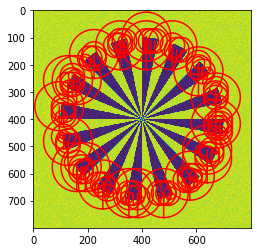

In [4]:
# Now Shi-Tomasi
gftt_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=kornia.feature.CornerGFTT(),
                                    nms_module=nms,
                                    mr_size=mr_size)

lafs, resps = gftt_local_detector(timg)
visualize_LAF(timg,lafs)

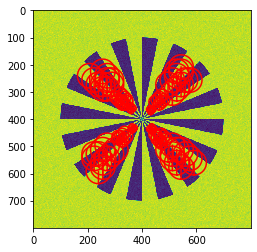

In [5]:
#And hessian blobs
hessian_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=kornia.feature.BlobHessian(),
                                    nms_module=nms,
                                    mr_size=mr_size)

lafs, resps = hessian_local_detector(timg)
visualize_LAF(timg,lafs)

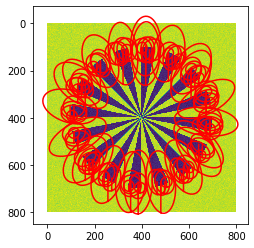

In [6]:
# What about harris-affine features?
harris_affine_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=kornia.feature.CornerHarris(0.04),
                                    nms_module=nms,
                                    mr_size=mr_size,
                                    aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19))

lafs, resps = harris_affine_local_detector(timg)
visualize_LAF(timg,lafs)

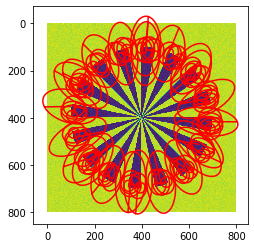

In [7]:
# Now lets also detect feature orientation
harris_affine_local_detector = ScaleSpaceDetector(n_feats, 
                                    resp_module=kornia.feature.CornerHarris(0.04),
                                    nms_module=nms,
                                    mr_size=mr_size,
                                    aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),
                                    ori_module=kornia.feature.LAFOrienter(patch_size=19))

lafs, resps = harris_affine_local_detector(timg)
visualize_LAF(timg,lafs)

In [8]:
#Lets describe patches with SIFT descriptor
descriptor = kornia.SIFTDescriptor(32)

patches =  kornia.feature.extract_patches_from_pyramid(timg, 
                                                        kornia.feature.normalize_laf(lafs,timg))
B, N, CH, H, W = patches.size()
# Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
# So we need to reshape a bit :) 
descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
print (descs.shape)
print (descs[0, 0])

torch.Size([1, 100, 128])
tensor([1.1244e-01, 1.1649e-01, 9.2973e-02, 5.7280e-02, 1.0674e-01, 1.0243e-01,
        6.3194e-02, 1.3349e-02, 8.8509e-02, 7.2944e-02, 2.2744e-02, 1.6186e-04,
        6.7305e-02, 4.5796e-02, 3.1385e-02, 2.6752e-02, 1.8188e-01, 2.1741e-01,
        2.2877e-01, 2.2163e-01, 2.3198e-01, 2.4138e-01, 2.4138e-01, 2.4138e-01,
        2.4138e-01, 2.4138e-01, 2.4138e-01, 2.4138e-01, 2.4138e-01, 2.4138e-01,
        2.4138e-01, 2.4138e-01, 2.0226e-02, 1.0000e-05, 1.0000e-05, 2.7590e-02,
        3.2786e-02, 1.0000e-05, 8.8336e-03, 5.9358e-02, 4.0607e-02, 4.0204e-03,
        4.4281e-02, 9.0924e-02, 4.3269e-02, 2.8809e-02, 7.5537e-02, 1.0541e-01,
        1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
        1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
        1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
        1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
        1.0000